# Import Dataset
## Load All images

In [1]:
#Load the dataset
import sys
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import time
import os
import pandas as pd

# Check Python version
if sys.version_info < (3, 7):
    raise Exception("Python version must be at least 3.7")

# Import Annotation
with open('dataset/TsignRecgTrain4170Annotation.txt', 'r') as f:
    actual_values = {}
    actual_name = []
    for l in f:
        l = l.strip().split(';')
        actual_values[l[0]] = (int(l[1]), int(l[2]), int(l[3]), int(l[4]), int(l[5]), int(l[6]))
        actual_name.append(l[0])

# Import file names
dirPath = 'dataset/dataset'
try:
    file_list = os.listdir(dirPath)
    image_files = [file for file in file_list if file != '.DS_Store']
    image_files = tuple(sorted(image_files))
except:
    print('Error in accessing image files.')
    sys.exit()


## Define the function

In [2]:
#functions defined

filename = []
iouValue = []
iouCheck = []

# Function to get actual sign coordinates
def getActualSign(seq):
    val = actual_values[getName(seq)]
    return val[2], val[3], val[4], val[5]

# Function to get image width and height
def getWidthHeight(seq):
    val = actual_values[getName(seq)]
    return val[0], val[1]  # return width, height

# Function to get image name
def getName(seq):
    return image_files[seq]

# Function to match color mask
def matchColorMask(inputImg, color):
    '''
    Args
    inputImg: hsv color-based image
    color: color type
    '''
    if color == 'red':
        lower_red = np.array([0, 100, 100])
        upper_red = np.array([10, 255, 255])
        lower_red2 = np.array([170, 71, 55])
        upper_red2 = np.array([180, 255, 255])
        mask_red = cv.inRange(inputImg, lower_red, upper_red)
        mask_red2 = cv.inRange(inputImg, lower_red2, upper_red2)
        mask_red = cv.bitwise_or(mask_red, mask_red2)
        return mask_red
    
    elif color == 'black':
        lower = np.array([0, 0, 0])
        upper = np.array([50, 50, 50])
    
    elif color == 'white':
        lower = np.array([200, 200, 200])
        upper = np.array([255, 255, 255])
    
    elif color == 'yellow narrow': # yellow within a narrow range, avoiding the background
        lower = np.array([9, 70, 39])
        upper = np.array([34, 255, 255])
    
    elif color == 'blue':
        lower = np.array([80, 140, 81])
        upper = np.array([144, 255, 255])
    
    elif color == 'yellow large': # yellow with a larger tolerance
        lower = np.array([9, 29, 55])
        upper = np.array([38, 255, 255])
    
    else:
        # Handle unsupported colors gracefully by returning an empty mask (all zeros)
        mask = np.zeros_like(inputImg[:, :, 0])
        return mask
    
    mask = cv.inRange(inputImg, lower, upper)
    return mask




## Dataset Pre-Processing

## ColorSpace Conversion - BGR to HSV

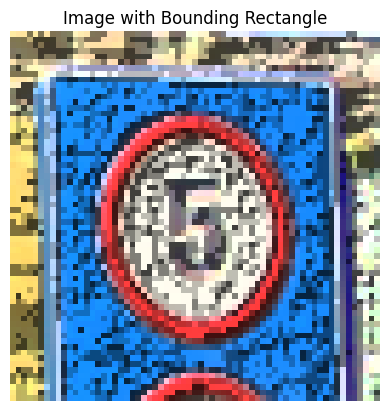

In [3]:
#Image Preprocessing
# Function for image preprocessing
def preprocessImage(img):
    # Applying noise reduction using GaussianBlur
    # blur = cv.GaussianBlur(img, (5, 5), 0)

    hsv_img = cv.cvtColor(img, cv.COLOR_BGR2HSV)

    # brightness adjustment by histogram equalization #To 
    h, s, v = cv.split(hsv_img)
    clahe = cv.createCLAHE(clipLimit=3, tileGridSize=(128, 128))
    equalized_v = clahe.apply(v)
    hsv_img = cv.merge([h, s, equalized_v])

    return hsv_img

# Loop through images and preprocess them
preprocessed_images = []

#display see see
for idx in range(len(image_files)):
    name = getName(idx)
    img = cv.imread('dataset/dataset/' + name)
    preprocessed_img = preprocessImage(img)
    preprocessed_images.append(preprocessed_img)

plt.imshow(cv.cvtColor(preprocessed_images[15], cv.COLOR_HSV2RGB))  # Convert HSV to RGB for Matplotlib
plt.title("Image with Bounding Rectangle")
plt.axis('off')  
plt.show()

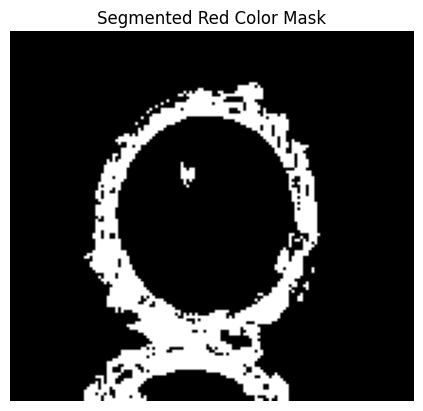

In [4]:
# Function for color segmentation
def colorSegmentation(hsv_img):
    color = ('red', 'black', 'white', 'yellow narrow', 'blue', 'yellow large')
    
    #store the binary mask in an array
    maskList = [matchColorMask(hsv_img, col) for col in color]
    
    return maskList

# Loop through preprocessed images and perform color segmentation
segmented_masks = []   #store all the masks
for idx in range(len(preprocessed_images)):
    hsv_img = preprocessed_images[idx]
    masks = colorSegmentation(hsv_img) # retrieve the mask for specific hsv image
    segmented_masks.append(masks) #append to store the masks
    
plt.imshow(segmented_masks[1][0], cmap='gray')  # 15 = image 16 , 0 = Display the red mask
plt.title("Segmented Red Color Mask")
plt.axis('off')  # Turn off axis labels
plt.show()


In [5]:
# Start Define function
# Function to get contours
def canny_auto(img, method, sigma=0.33):
    """
    Args
    img: grayscale
    method: median, triangle and otsu
    sigma=0.33 (default)
    """
    
    if method=='median': Th = np.median(img)
    elif method=='triangle': Th = cv.threshold(img, 0, 255, cv.THRESH_TRIANGLE)[0]
    elif method=='otsu': Th = cv.threshold(img, 0, 255, cv.THRESH_OTSU)[0]
    else: raise Exeption("method specified not available!")
        
    lowThresh = (1-sigma) * Th
    highThresh = (1+sigma) * Th
    
    return cv.Canny(img, lowThresh, highThresh)

def getContours(mask):
    '''get the largest contour from color mask'''
    
    # perform color thresholding
    _, img_binary = cv.threshold(mask, 0, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
    kernel = np.ones((8, 8), dtype=np.uint8)
    erosion = cv.erode(img_binary, kernel, iterations=1)
    dilation = cv.dilate(erosion, kernel, iterations=1)

    # Edge Detection
    edges = canny_auto(dilation, 'triangle')

    # Contour Formation
    contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    try:
        return max(contours, key=cv.contourArea)
    except:
        return None

# Function to get the largest contour
def getLargestContour(contours):
    '''find largest contour'''
    
    conArea = []
    maxCon = contours[0]
    for c in contours:
        try:
            if c is not None and cv.contourArea(c) > cv.contourArea(maxCon): maxCon = c
        except:
            return None

    return maxCon

# Function for edge detection and contour formation
def edgeDetectionAndContour(img, color):
    mask = matchColorMask(img, color)
    contour = getContours(mask)
    return contour

# End Define function

# Loop through preprocessed images and perform contour detection
color = ('red', 'black', 'white', 'yellow narrow', 'blue', 'yellow large')

# Loop through preprocessed images and perform contour detection for each color
#for later use, find the largest contour
# Loop through the preprocessed images and display the largest contour for each color
# Initialize a list to store the largest contours for all images
largest_contours_list = []

# Loop through the preprocessed images and store the largest contour for each color
for idx in range(len(preprocessed_images)):
    image_name = getName(idx)
    hsv_img = preprocessed_images[idx]

    # Initialize a list to store contours for all colors for this image
    all_contours = []

    for color_name in color:
        contour = edgeDetectionAndContour(hsv_img, color_name)
        if contour is not None:
            all_contours.append(contour)

    # Find the largest contour among all the detected contours
    largest_contour = getLargestContour(all_contours)

    # Append the largest contour to the list
    largest_contours_list.append( largest_contour)



In [6]:
largest_contours_list[1]

array([[[ 64,  30]],

       [[ 63,  31]],

       [[ 62,  31]],

       [[ 61,  32]],

       [[ 60,  32]],

       [[ 59,  33]],

       [[ 57,  33]],

       [[ 56,  34]],

       [[ 55,  34]],

       [[ 53,  36]],

       [[ 52,  36]],

       [[ 45,  43]],

       [[ 45,  44]],

       [[ 43,  46]],

       [[ 43,  47]],

       [[ 42,  48]],

       [[ 42,  49]],

       [[ 41,  50]],

       [[ 41,  52]],

       [[ 40,  53]],

       [[ 40,  54]],

       [[ 39,  55]],

       [[ 39,  57]],

       [[ 38,  58]],

       [[ 38,  72]],

       [[ 39,  73]],

       [[ 39,  76]],

       [[ 42,  79]],

       [[ 42,  81]],

       [[ 43,  82]],

       [[ 43,  83]],

       [[ 44,  84]],

       [[ 44,  85]],

       [[ 45,  86]],

       [[ 45,  87]],

       [[ 48,  90]],

       [[ 48,  91]],

       [[ 51,  94]],

       [[ 53,  94]],

       [[ 55,  96]],

       [[ 56,  96]],

       [[ 58,  98]],

       [[ 59,  98]],

       [[ 60,  99]],

       [[ 73,  99]],

       [[ 

## Below section are:
   - Get bounding box info: x,y,w,h, basded on largest contour in each image
   - Draw a mask for largest contour in each image
   - Extract the area of interest

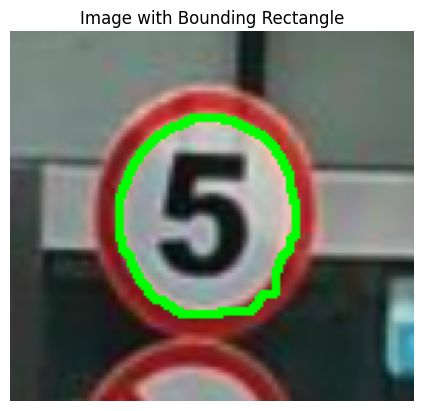

In [7]:
bound_img_list = []
box_pred_ori = [] #for counting the inclusive result
box_pred = []  # Append the x, y, w, h values in this array # for later calculate IOU

mask_for_region_of_Interest = []
for idx in range(len(preprocessed_images)):
    image_name = getName(idx)
    ori_img = cv.imread('dataset/dataset/' + image_name)
    
    # Check if the contour is not empty before drawing
    if largest_contours_list[idx] is not None:
        # 5. Bounding Box Computation
        x, y, w, h = cv.boundingRect(largest_contours_list[idx])#xy coordiante, wh width height of contour
        
        box_pred_value_ori = x,y,w,h
        box_pred_ori.append(box_pred_value_ori)
        
        box_pred_value = x,y,x+w,y+h
        box_pred.append(box_pred_value)  #store the boundding
        
        boundImg = cv.drawContours(ori_img.copy(), [largest_contours_list[idx]], -1, (0, 255, 0), 2)
        bound_img_list.append(boundImg)
        
        # Create a mask for the largest contour
        maskBackground = np.zeros_like(cv.cvtColor(ori_img, cv.COLOR_BGR2GRAY))
        cv.drawContours(maskBackground, [largest_contours_list[idx]], -1, 255, thickness=cv.FILLED)

        # Extract the region of interest using the mask
        contour_area = cv.bitwise_and(ori_img.copy(), ori_img.copy(), mask=maskBackground)
        mask_for_region_of_Interest.append(contour_area)
        
    else:
        # Handle the case where no contour was found (optional)
        # You can choose to skip this image or do something else
        # For now, we'll append a None to the box_pred list
        print("contour " , idx ," is null")
        box_pred.append([0,0,0,0])
        

#show the 16th image with a bounding contour
plt.imshow(cv.cvtColor(bound_img_list[1], cv.COLOR_BGR2RGB))
plt.title("Image with Bounding Rectangle")
plt.axis('off')  # Turn off axis labels
plt.show()

## Calculate IOU

In [8]:
# calculate the IOU
def computeIOU(boxA, boxB):
    """
    Args
    boxA: ground truth
    boxB: prediction
    They are list of points.
    """
    
    x_start = max(boxA[0], boxB[0])
    y_start = max(boxA[1], boxB[1])
    x_end = min(boxA[2], boxB[2])
    y_end = min(boxA[3], boxB[3])
    
    # compute the intersection area
    interArea = max(0, x_end - x_start + 1) * max(0, y_end - y_start + 1)
    
    # area of box A and box B
    areaA = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    areaB = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    return interArea / (areaA + areaB - interArea)
iou_list=[]

for idx in range(len(preprocessed_images)):
    boxActual = getActualSign(idx)
    boxPred = box_pred[idx]     # define before
    iou= computeIOU(boxPred, boxActual)
    iou_list.append(iou)
   


In [9]:
# Loop through the IoU values in iou_list
trueTotal = []
falseTotal = []
zero = []
iouCheck = []
#for later csv file
filename=[]

threshold = 0.55
count_iou_greater_than_threshold = 0
idx = 0
for iou in iou_list:
    if iou > threshold:
        count_iou_greater_than_threshold += 1
        trueTotal.append(idx)
    else:
        if box_pred_ori[idx][0]==box_pred_ori[idx][2]: zero.append(idx)
        else: falseTotal.append(idx)
    
    
    # construct the result table
    filename.append(getName(idx))
    iouValue.append(iou)
    if iou >= 0.55: iouCheck.append(True)
    else: iouCheck.append(False)
    idx=idx+1

print("Total IoU values greater than", threshold,": ", count_iou_greater_than_threshold)

Total IoU values greater than 0.55 :  131


## Statistical Result 

In [10]:
def printStatisResult():
    print(f"Total number of inconclusive results: {len(zero)}")
    print(f"Total number of incorrect results: {len(falseTotal)}")
    print(f"Total number of correct results: {len(trueTotal)}")
    
    print(f"\nTotal number of samples: {len(preprocessed_images)}")

import time

# Define a timestamp before starting the processing



printStatisResult()
print(f"Accuracy: {(len(trueTotal)/len(preprocessed_images))*100:.2f}%")



Total number of inconclusive results: 2
Total number of incorrect results: 39
Total number of correct results: 131

Total number of samples: 172
Accuracy: 76.16%


## Export to CSV to view the result

In [11]:
def getTable():
    global data
    data = {}
    
    data['Name'] = [x for x in filename]
    data['IOU'] = [x for x in iou_list]
    data['IOU >= 0.55'] = [x for x in iouCheck]
    
    df = pd.DataFrame(data)
    
    print(df)
    df.to_csv('dataset/output/table.csv', index=False)
    
getTable()

               Name       IOU  IOU >= 0.55
0      000_0003.png  0.601373         True
1    000_0008_j.png  0.679426         True
2      000_0010.png  0.569444         True
3      000_0016.png  0.585534         True
4      000_0017.png  0.659368         True
..              ...       ...          ...
167  056_1_0006.png  0.520963        False
168  056_1_0010.png  0.958639         True
169  056_1_0016.png  0.970909         True
170  056_1_0039.png  0.973249         True
171  057_1_0002.png  0.944528         True

[172 rows x 3 columns]


## Output the Segmented Image to png file

In [12]:
def outImage():
    i = 0
    try:
        for image in mask_for_region_of_Interest:
            # Convert 'i' to a string and include a file extension (e.g., '.png')
            filename = f'dataset/Segmented image/{i}.png'
            cv.imwrite(filename, image)
            i += 1  # Increment 'i' to generate unique filenames
        print(True)
    except:
        print(False)

outImage()


True


In [13]:
def compareOriginalAndSegmentedImages(idx):
    # Load the original and segmented images for the given index
    original_img = cv.imread('dataset/dataset/' + getName(idx))
    segmented_img = mask_for_region_of_Interest[idx]
    
    # Calculate the IOU for this image
    boxActual = getActualSign(idx)
    boxPred = box_pred[idx]     # define before
    iou= computeIOU(boxPred, boxActual)
   
    return original_img, segmented_img, iou


## Display the result (Sequentially) with IOU > 0.55

In [ ]:
#display sequantialy 

# Create an array to store results with IOU > 0.55
iou_above_threshold = []

# Iterate through all indices and append results with IOU > 0.55
for idx in range(len(preprocessed_images)):
    original_img, segmented_img, iou = compareOriginalAndSegmentedImages(idx)
    if iou > 0.55:
        iou_above_threshold.append((idx, original_img, segmented_img, iou))
print("Results that have IOU > 0.55: ", len(iou_above_threshold))

# Define the number of results to display (user-defined)
num_results_to_display = 150  # You can change this number as needed

# Take a subset of results for display
selected_results = iou_above_threshold[:num_results_to_display]

# Create a subplot
fig, axs = plt.subplots(num_results_to_display, 3, figsize=(10, num_results_to_display * 3))

# Iterate through the selected results and display them sequentially
for i, (idx, original_img, segmented_img, iou) in enumerate(selected_results):
    # Retrieve the original image file name based on the index
    image_name = getName(idx)
    
    axs[i, 0].imshow(cv.cvtColor(original_img, cv.COLOR_BGR2RGB))
    axs[i, 0].set_title(f"Original - {image_name}")
    axs[i, 0].axis('off')
    
    axs[i, 1].imshow(cv.cvtColor(segmented_img, cv.COLOR_BGR2RGB))
    axs[i, 1].set_title(f"Segmented - {image_name}")
    axs[i, 1].axis('off')
    
    axs[i, 2].text(0.5, 0.5, f"IOU: {iou:.2f}", fontsize=12, ha='center')
    axs[i, 2].axis('off')

plt.tight_layout()
plt.show()


## Display the result with IOU <= 0.55 (Randomly select, can set the number to be display)

In [ ]:
import random
import matplotlib.pyplot as plt

# Create an array to store results with IOU > 0.55
iou_above_threshold = []

# Iterate through all indices and append results with IOU > 0.55
for idx in range(len(preprocessed_images)):
    original_img, segmented_img, iou = compareOriginalAndSegmentedImages(idx)
    if iou <= 0.55:
        iou_above_threshold.append((idx, original_img, segmented_img, iou))
print("Result that have IOU <= 0.55 : ", len(iou_above_threshold))
# Shuffle the array to randomize the order
random.shuffle(iou_above_threshold)

# Define the number of results to display (user-defined)
num_results_to_display = 10  # You can change this number as needed

# Take a random subset of results for display
selected_results = iou_above_threshold[:num_results_to_display]

# Create a subplot
fig, axs = plt.subplots(num_results_to_display, 3, figsize=(10, num_results_to_display * 3))

# Iterate through the selected results and display them
for i, (idx, original_img, segmented_img, iou) in enumerate(selected_results):
    axs[i, 0].imshow(cv.cvtColor(original_img, cv.COLOR_BGR2RGB))
    axs[i, 0].set_title(f"Original - Image {idx}")
    axs[i, 0].axis('off')
    
    axs[i, 1].imshow(cv.cvtColor(segmented_img, cv.COLOR_BGR2RGB))
    axs[i, 1].set_title(f"Segmented - Image {idx}")
    axs[i, 1].axis('off')
    
    axs[i, 2].text(0.5, 0.5, f"IOU: {iou:.2f}", fontsize=12, ha='center')
    axs[i, 2].axis('off')

plt.tight_layout()
plt.show()


## Display the result with IOU >= 0.55 (Randomly select, can set the number to be display)


In [ ]:
#display randomly
import random
import matplotlib.pyplot as plt

# Create an array to store results with IOU > 0.55
iou_above_threshold = []

# Iterate through all indices and append results with IOU > 0.55
for idx in range(len(preprocessed_images)):
    original_img, segmented_img, iou = compareOriginalAndSegmentedImages(idx)
    if iou > 0.55:
        iou_above_threshold.append((idx, original_img, segmented_img, iou))
print("Result that have IOU > 0.55 : ", len(iou_above_threshold))
# Shuffle the array to randomize the order
random.shuffle(iou_above_threshold)

# Define the number of results to display (user-defined)
num_results_to_display = 150  # You can change this number as needed

# Take a random subset of results for display
selected_results = iou_above_threshold[:num_results_to_display]

# Create a subplot
fig, axs = plt.subplots(num_results_to_display, 3, figsize=(10, num_results_to_display * 3))

# Iterate through the selected results and display them
for i, (idx, original_img, segmented_img, iou) in enumerate(selected_results):
    axs[i, 0].imshow(cv.cvtColor(original_img, cv.COLOR_BGR2RGB))
    axs[i, 0].set_title(f"Original - Image {idx}")
    axs[i, 0].axis('off')
    
    axs[i, 1].imshow(cv.cvtColor(segmented_img, cv.COLOR_BGR2RGB))
    axs[i, 1].set_title(f"Segmented - Image {idx}")
    axs[i, 1].axis('off')
    
    axs[i, 2].text(0.5, 0.5, f"IOU: {iou:.2f}", fontsize=12, ha='center')
    axs[i, 2].axis('off')

plt.tight_layout()
plt.show()